In [1]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

In [2]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import os
import glob
import re
import math

import missingno as msno
import pickle
import bz2
import statsmodels.api as sm

import sklearn
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import set_config
from pca import pca
#from sklearn import missingpy
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
'''Open pickled file'''
with open('mib_final.pkl', 'rb') as f:
    df = pickle.load(f)

<AxesSubplot:>

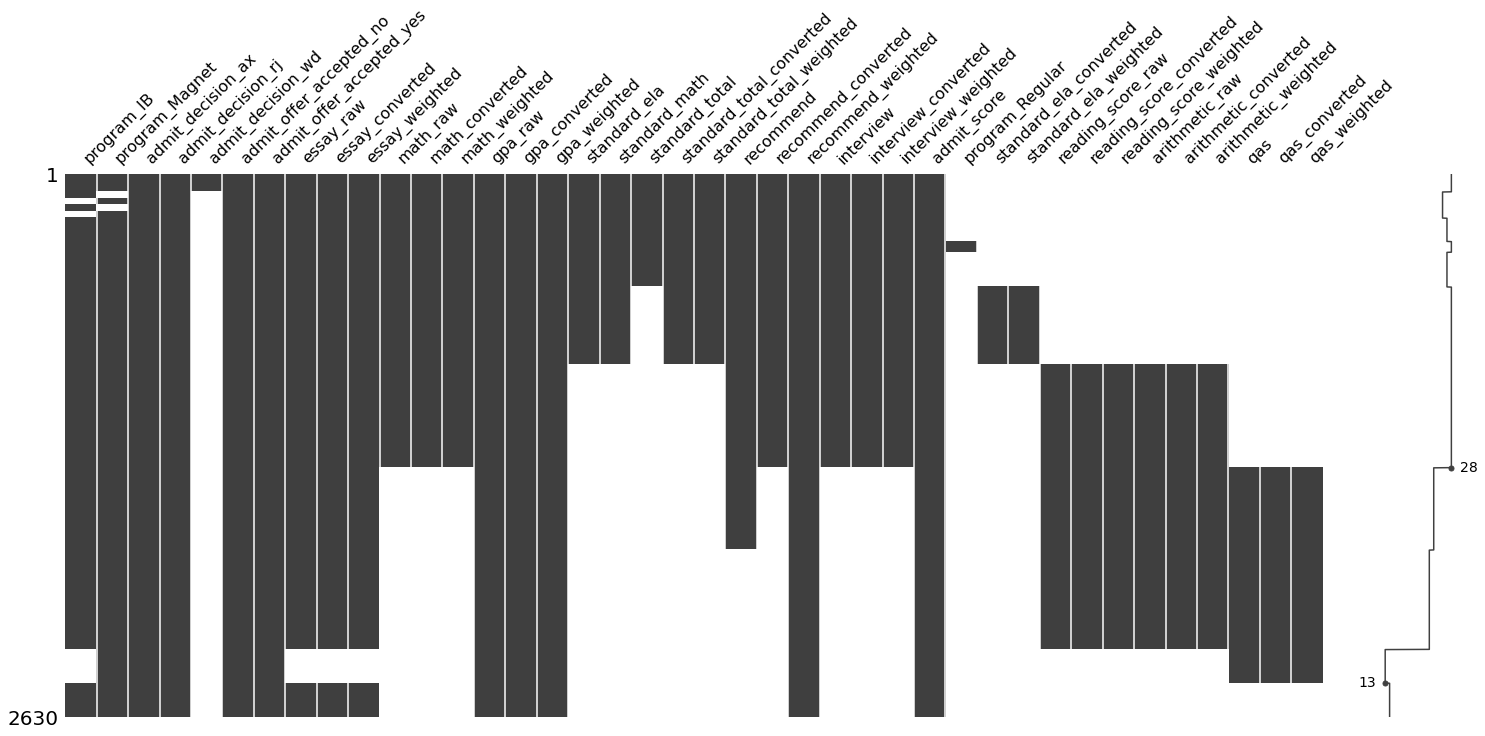

In [4]:
msno.matrix(df)

In [5]:
'''Combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['arithmetic_raw'])
df['math_converted'] = df['math_converted'].combine_first(df['arithmetic_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['arithmetic_weighted'])

df['standard_ela'] = df['standard_ela'].combine_first(df['reading_score_raw'])

<AxesSubplot:>

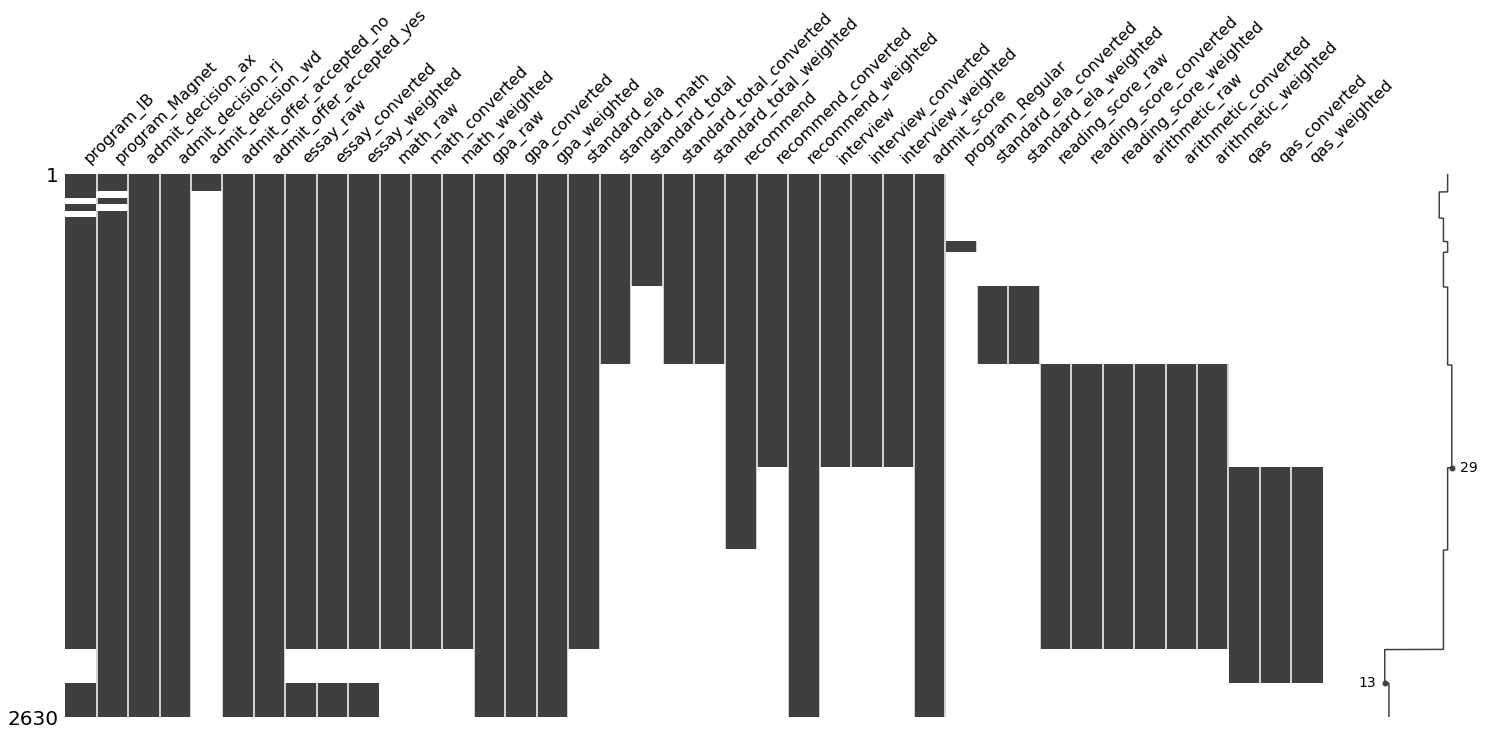

In [6]:
msno.matrix(df)

In [7]:
'''Further combine data columns'''
df['math_raw'] = df['math_raw'].combine_first(df['qas'])
df['math_converted'] = df['math_converted'].combine_first(df['qas_converted'])
df['math_weighted'] = df['math_weighted'].combine_first(df['qas_weighted'])

<AxesSubplot:>

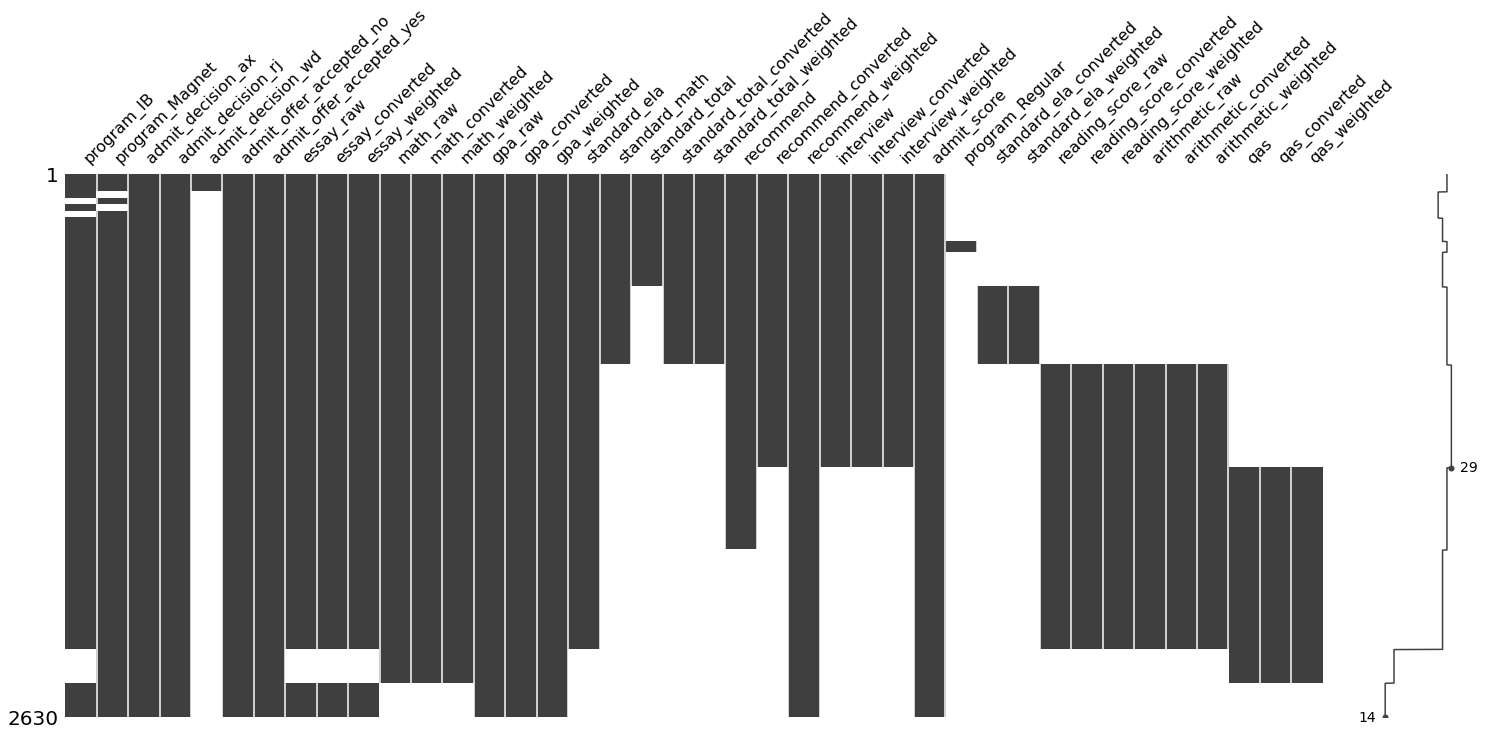

In [8]:
msno.matrix(df)

In [9]:
'''Drop duplicate and/or sparse columns'''
df.drop(['admit_decision_wd', 'standard_math', 'standard_total', 'standard_total_converted', 'standard_total_weighted',\
         'program_Regular','standard_ela_converted', 'standard_ela_weighted', 'reading_score_raw','reading_score_converted',\
         'reading_score_weighted', 'arithmetic_raw', 'arithmetic_converted', 'arithmetic_weighted', 'qas', 'qas_converted',\
         'qas_weighted'], axis = 1, inplace=True)

<AxesSubplot:>

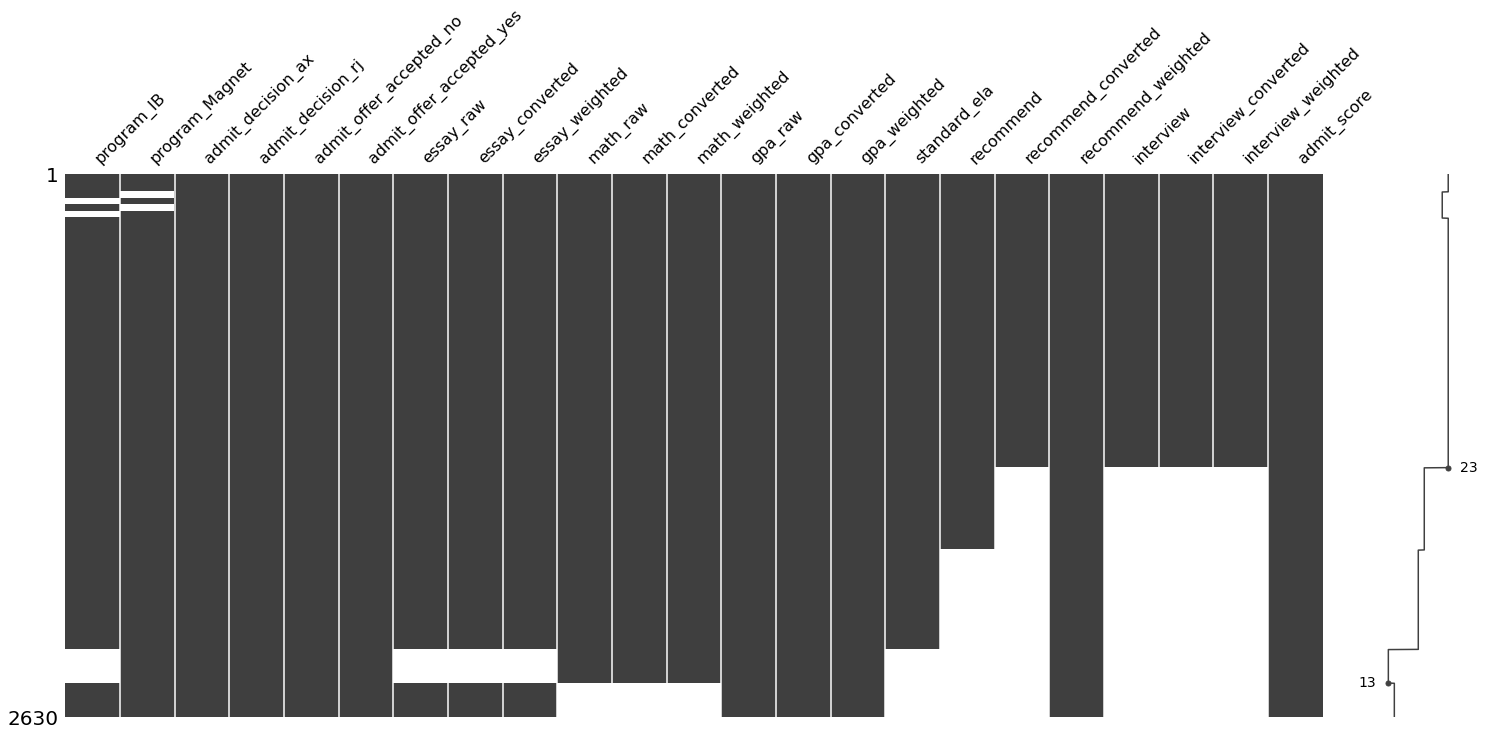

In [10]:
msno.matrix(df)

In [12]:
'''Fill NaNs in program columns'''

df['program_IB'].replace(np.nan, 0, inplace = True)
df['program_Magnet'].replace(np.nan, 0, inplace = True)

In [13]:
'''Create column for program/acceptance status'''
conditions = [
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 0) & (df['admit_decision_ax'] == 1),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 0),
    (df['program_IB'] == 1) & (df['admit_decision_ax'] == 1)]

values = ['Magnet-Rejected', 'Magnet-Accepted', 'IB-Rejected', 'IB-Accepted']

df['program_admit'] = np.select(conditions, values)

In [14]:
'''Create separate dataframes for magnet and ib'''
ib_df = df.loc[df['program_IB'] == 1]
magnet_df = df.loc[df['program_Magnet'] == 1]

In [15]:
df.columns
plot_list = ['program_admit','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']

In [16]:
def qq_plot (df):
    for column in df.columns:
        print(column)
        sm.qqplot(df[column], line ='s', fit = True)

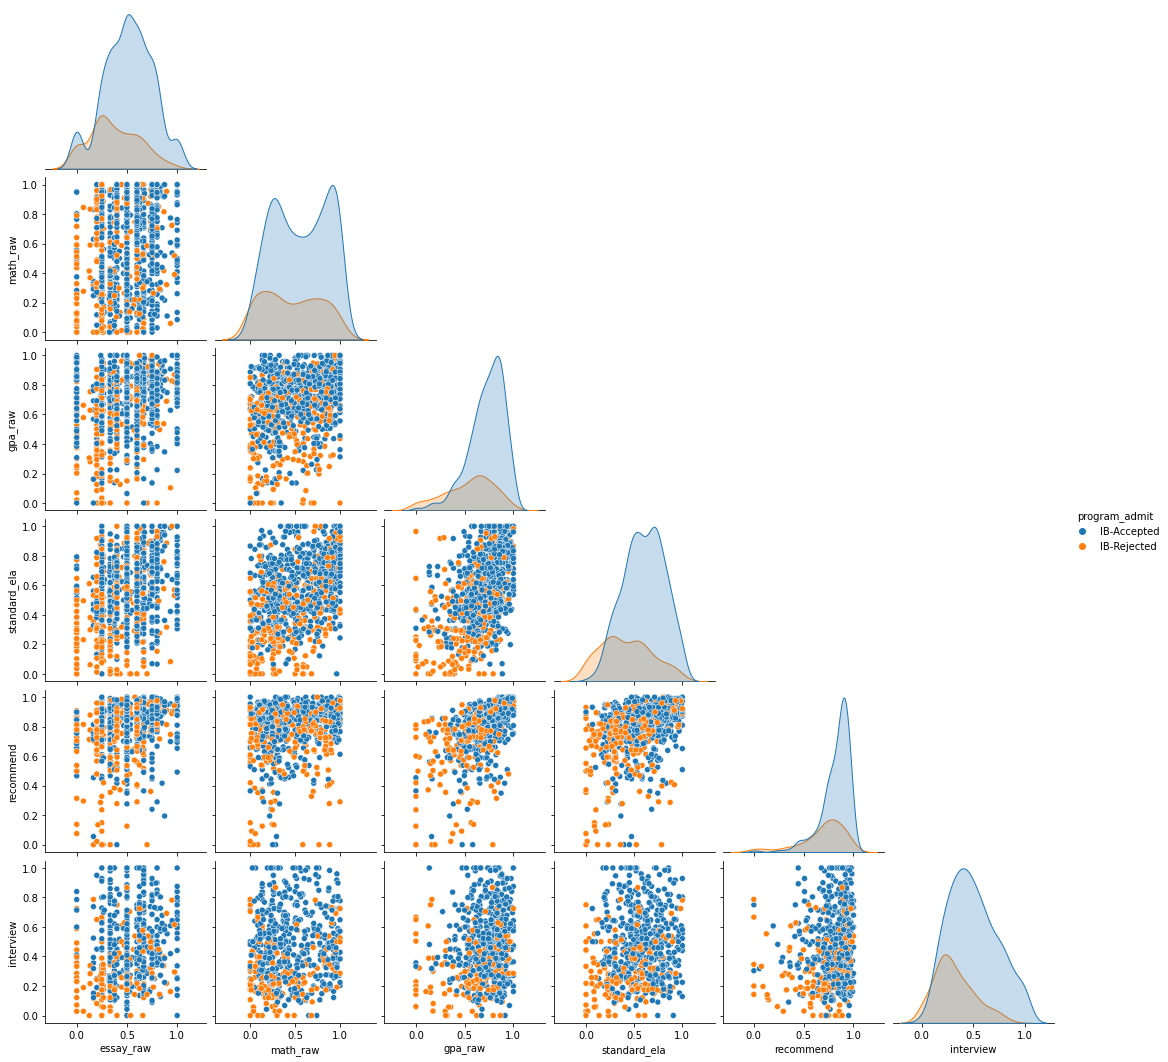

In [17]:
'''Create pariplots to show relationships between variables - IB'''
sns.pairplot(ib_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

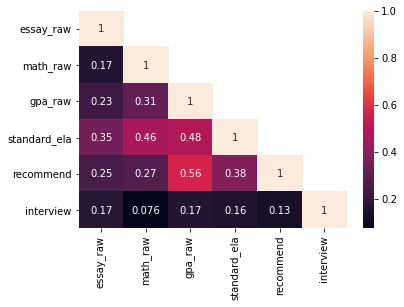

In [18]:
'''Correlation Heatmap - IB'''
df_corr_ib = ib_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_ib), columns = df_corr_ib.columns).replace(0, np.nan)
matrix.set_index(df_corr_ib.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

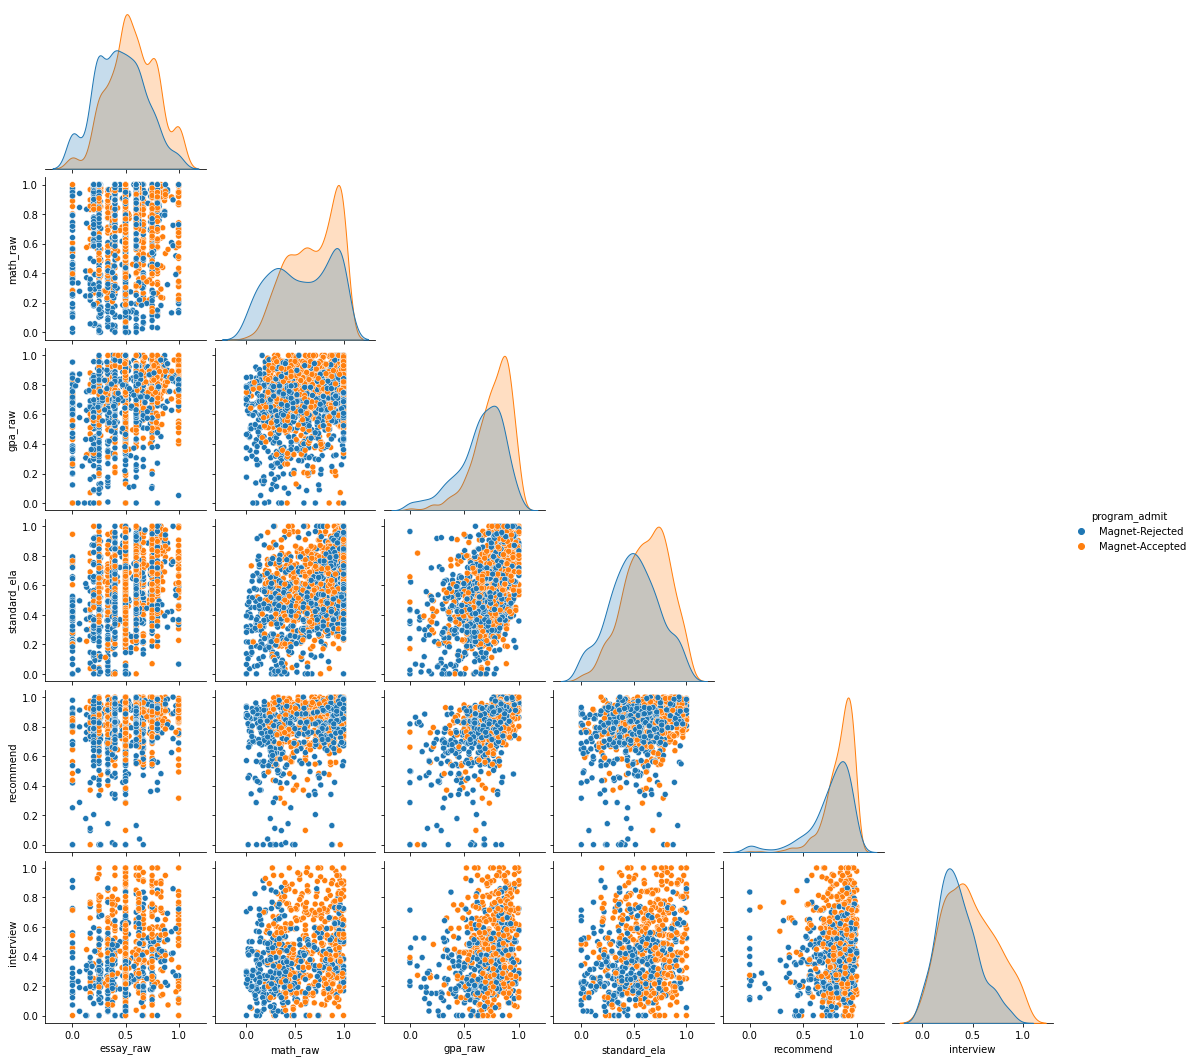

In [19]:
'''Create pariplots to show relationships between variables - Magnet'''
sns.pairplot(magnet_df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

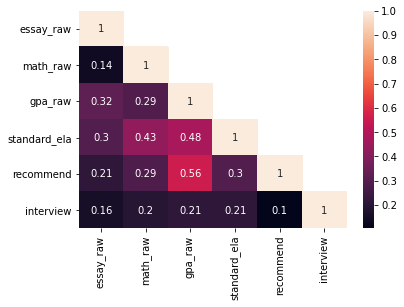

In [20]:
'''Correlation Heatmap - Magnet'''
df_corr_magnet = magnet_df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr_magnet), columns = df_corr_magnet.columns).replace(0, np.nan)
matrix.set_index(df_corr_magnet.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

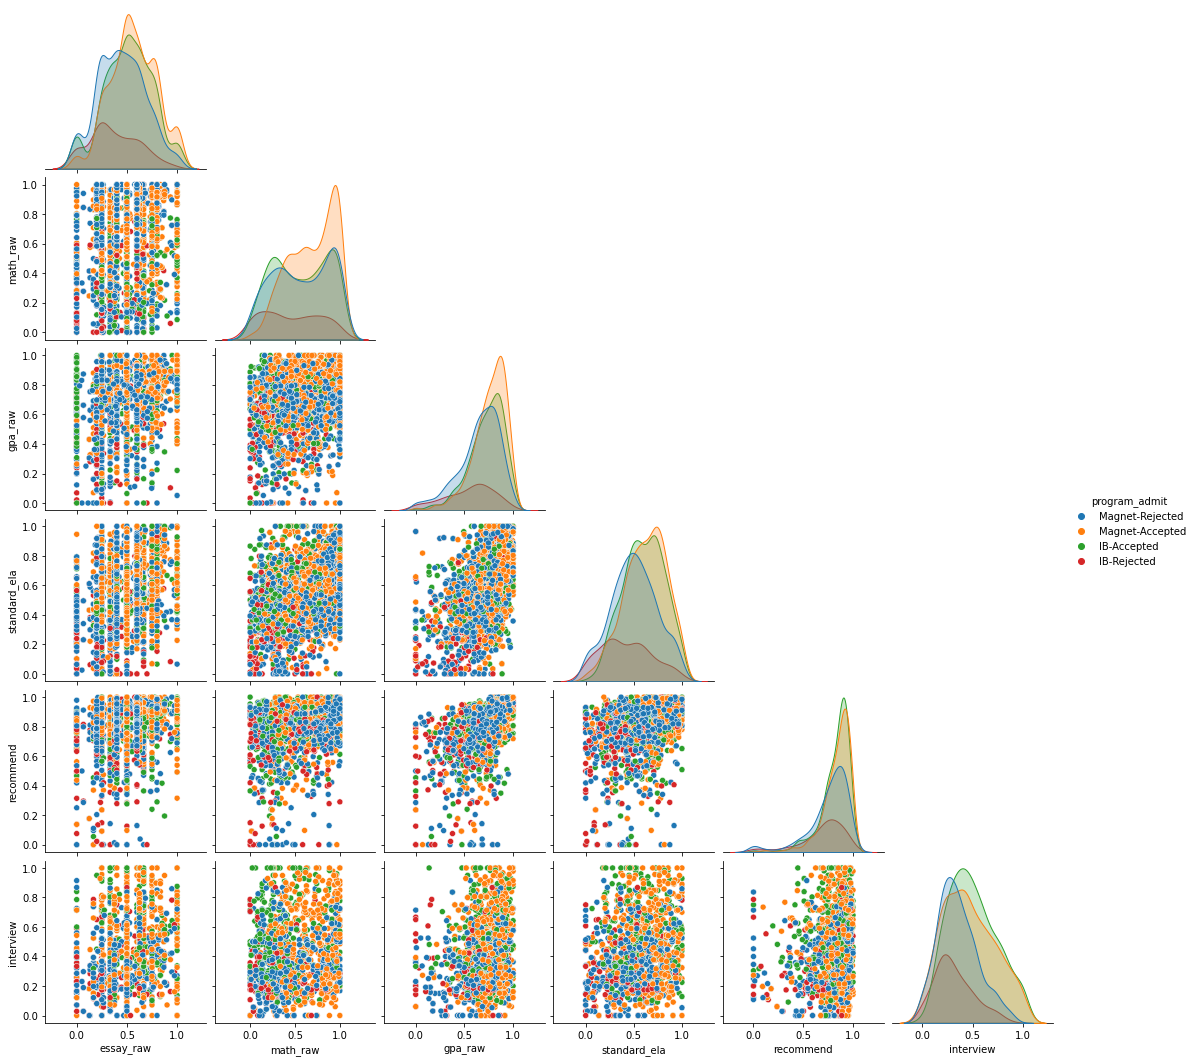

In [21]:
'''Create pariplots to show relationships between variables'''
sns.pairplot(df[plot_list], kind = 'scatter', hue = 'program_admit', corner = True)

<AxesSubplot:>

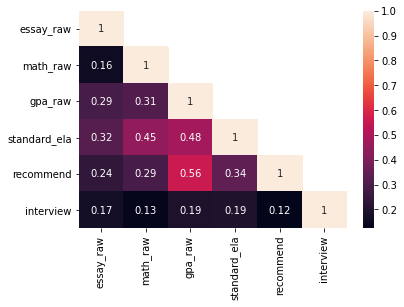

In [22]:
'''Correlation Heatmap for both programs'''
df_corr = df[plot_list].corr()
matrix = pd.DataFrame(np.tril(df_corr), columns = df_corr.columns).replace(0, np.nan)
matrix.set_index(df_corr.columns, drop = True, inplace = True)
sns.heatmap(matrix, annot=True)

In [23]:
'''Function to perform PCA analysis'''

'''Split data into test and train IB'''
def conduct_pca(df, pca_list, n_components):
    X = df[pca_list].drop(pca_list[0], axis = 1)
    y = df[pca_list[0]].astype('int32')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y, random_state=42)
    
    '''Create PCA model'''
    pca = PCA(n_components = n_components)
    pca.fit(X_train, y_train)
    
    '''Find cumulative variance of components'''
    cum_variance = np.cumsum(pca.explained_variance_ratio_*100)
    variance = pca.explained_variance_ratio_*100

    '''Print explained variance with all factors'''
    print(f'Cumulative variance explained by model {cum_variance}')
    print(f'The explained variance for each factor is: {variance}')
    
    '''Create Scree Plot'''
    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Proportion of Variance Explained')
    plt.xticks(np.arange(1,6,1));

    return pca, X, y, X_train, X_test, y_train, y_test

In [24]:
'''Function to draw PCA biplot retreived from: 
https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot'''

def myplot(score, coeff, y, labels = None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    plt.scatter(xs * scalex, ys * scaley, c=y)

    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

### IB PCA Analysis

<AxesSubplot:>

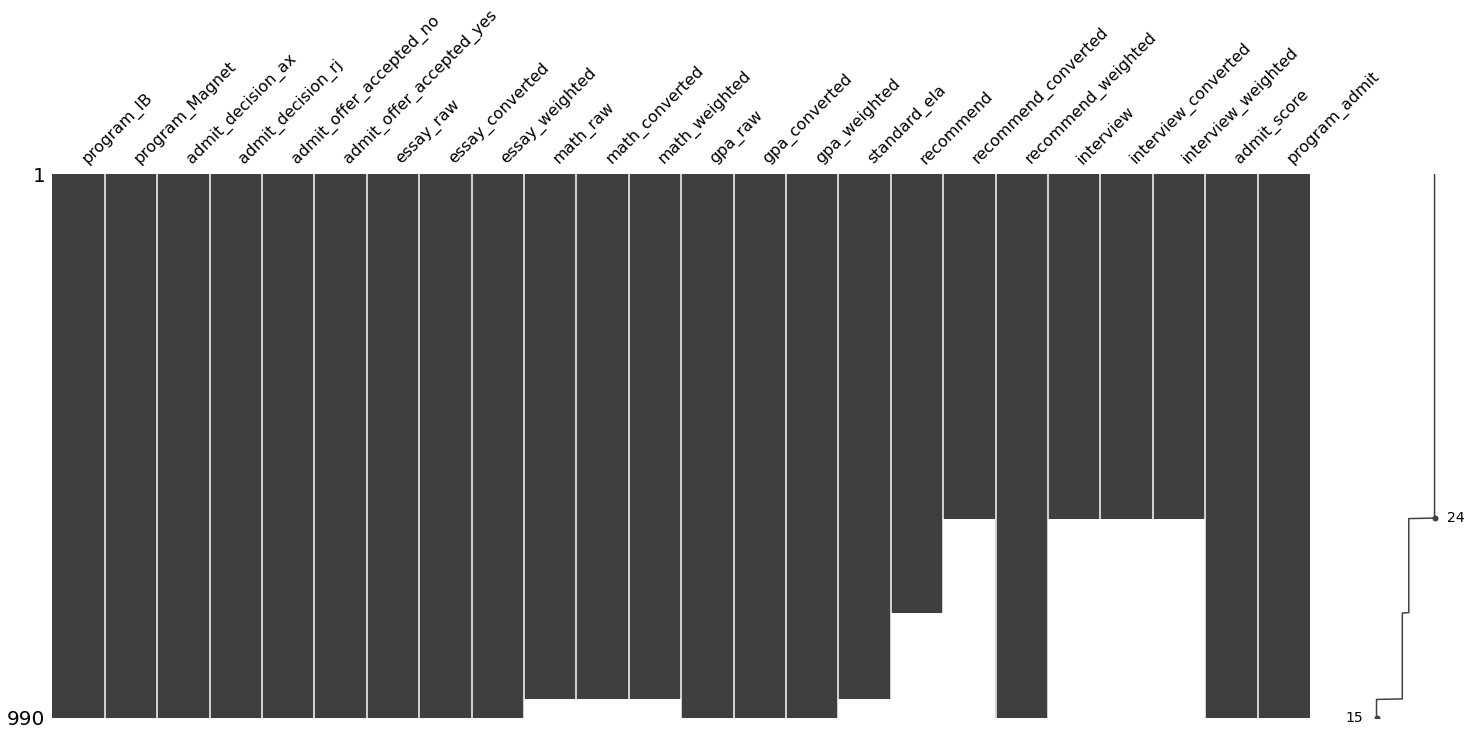

In [25]:
msno.matrix(ib_df)

In [26]:
ib_df_drop = ib_df.dropna(how = 'any')

<AxesSubplot:>

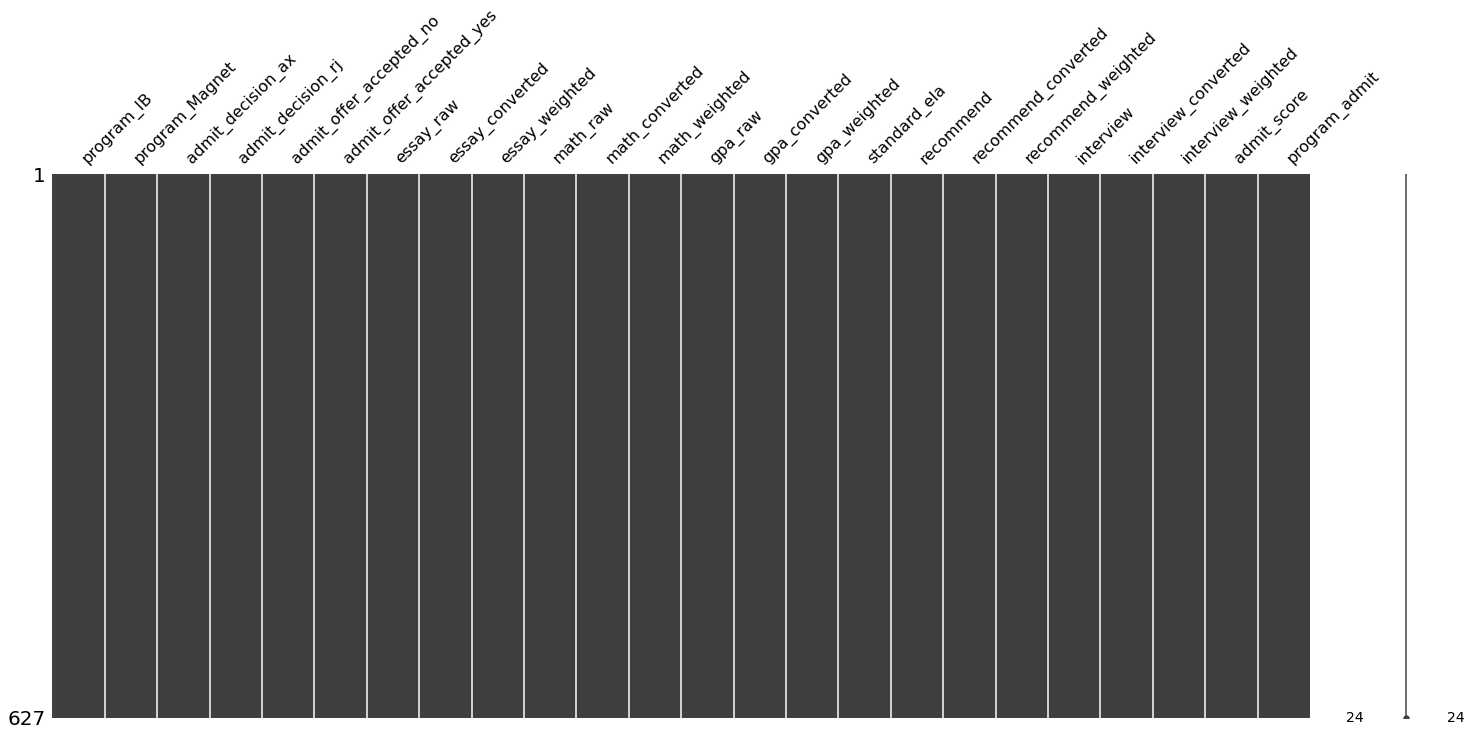

In [27]:
msno.matrix(ib_df_drop)

essay_raw
math_raw
gpa_raw
standard_ela
recommend
interview


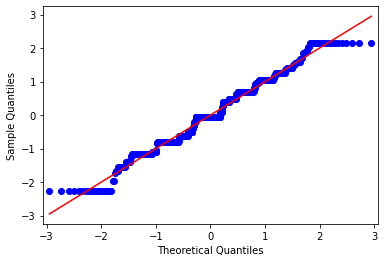

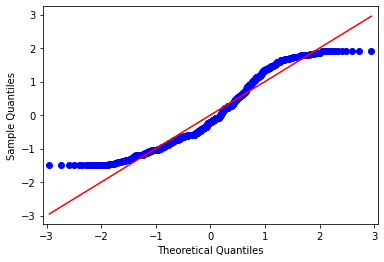

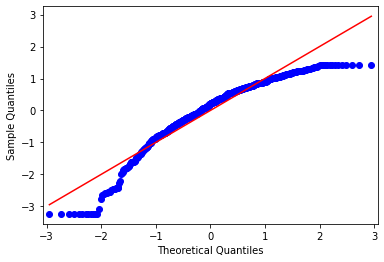

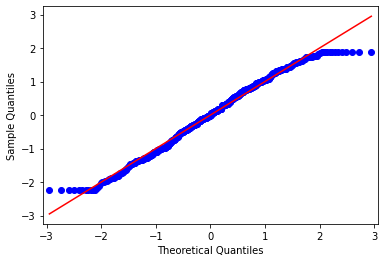

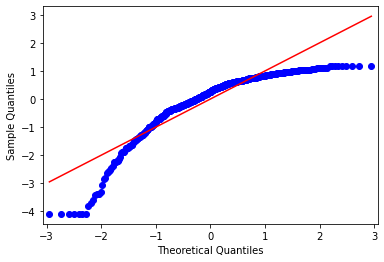

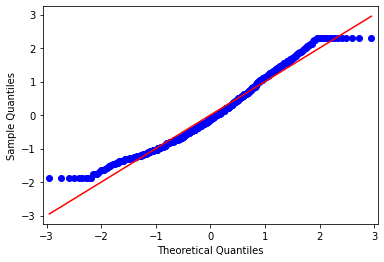

In [28]:
qq_plot(ib_df_drop[plot_list].drop('program_admit', axis = 1))

In [ ]:
'''Conduct PCA on IB data with 6 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_df_drop, pca_list, 6)

In [ ]:
'''Conduct PCA on IB data with 2 components'''
pca_list = ['program_IB','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(ib_df_drop, pca_list, 2)

In [ ]:
'''Calculate pc loadings - IB'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

In [ ]:
'''Transform IB Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

In [ ]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1], hue = y_test)
plt.xlabel('Component 1')
plt.ylabel('Component 2');

In [ ]:
'''Create biplot for IB PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)

### Magnet PCA Analysis

In [ ]:
magnet_df_drop = magnet_df.dropna(how = 'any')

In [ ]:
msno.matrix(magnet_df_drop)

In [ ]:
'''Conduct PCA on Magnet data with 6 components'''
pca_list = ['program_Magnet','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_drop, pca_list, 6)

In [ ]:
'''Conduct PCA on Magnet data with 2 components'''
pca_list = ['program_Magnet','essay_raw', 'math_raw', 'gpa_raw','standard_ela', 'recommend', 'interview']
pca, X, y, X_train, X_test, y_train, y_test = conduct_pca(magnet_df_drop, pca_list, 2)

In [ ]:
'''Calculate pc loadings - Magnet'''
pd.options.display.float_format = '{:,.4f}'.format
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=X_train.columns)
loadings

In [ ]:
'''Transform Magnet Data'''
pca_trans = pca.transform(X_test)
pca_trans_df = pd.DataFrame(pca_trans, columns = ['PC1', 'PC2'])

In [ ]:
'''Plot Primary Components'''
plt.figure(figsize=(10,5))
sns.scatterplot(x = pca_trans[:,0], y = pca_trans[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2');

In [ ]:
'''Create biplot for Magnet PCA'''
myplot(pca_trans[:,0:2],np.transpose(pca.components_[0:2, :]), y_test)